# To Do

- Change dtypes of all columns to the correct ones.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb

from pathlib import Path
from lightgbm import LGBMClassifier
from pprint import pprint

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

############ USE FOR GOOGLE COLAB ############
# DATA_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/Earthquake_damage/data')
# SUBMISSIONS_DIR = Path('drive/MyDrive/Work/Delivery/Current/Earthquake_damage/submissions')
# MODEL_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/Earthquake_damage/models')
# MY_DATA_DIR = PATH('/content/drive/MyDrive/Work/Delivery/Current/Earthquake_damage/my_data')

# from google.colab import drive
# drive.mount('/content/drive')
#############################################


### USE FOR LOCAL JUPYTER NOTEBOOKS ###
DATA_DIR = Path('data')
SUBMISSIONS_DIR = Path('submissions')
MODEL_DIR = Path('models')
MY_DATA_DIR = Path('my_data')
#######################################

# The code runs the same if working on Jupyter or Colab, just need to change the 
# dirs above

X = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')

categorical_columns = X.select_dtypes(include='object').columns
bool_columns = [col for col in X.columns if col.startswith('has')]
X[categorical_columns] = X[categorical_columns].astype('category')
X[bool_columns] = X[bool_columns].astype('bool')

# X = pd.get_dummies(X)
y = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

lgbm_hyperparams = {'num_leaves': 120,
                    'n_estimators': 240,
                    'min_child_samples': 40,
                    'learning_rate': 0.2,
                    'boosting_type': 'goss'}

In [2]:
sns.set()

In [3]:
df_all = X.join(y)

In [7]:
# Features with importance >= 100 after training LightGBM model on all features
most_important_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
                           'count_floors_pre_eq', 'age'	, 'area_percentage'	, 
                           'height_percentage', 
                           'has_superstructure_mud_mortar_stone',
                           'has_superstructure_stone_flag', 
                           'has_superstructure_mud_mortar_brick',
                           'has_superstructure_cement_mortar_brick',
                           'has_superstructure_timber', 'count_families',
                           'other_floor_type_q']	

In [8]:
X_imp = X[most_important_features]

In [10]:
X_imp.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,count_families,other_floor_type_q
building_id,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,True,False,False,False,False,1,1
28830,8,900,2812,2,10,8,7,True,False,False,False,False,1,1
94947,21,363,8973,2,10,5,5,True,False,False,False,False,1,0
590882,22,418,10694,2,10,6,5,True,False,False,False,True,1,0
201944,11,131,1488,3,30,8,9,False,False,False,False,False,1,0


In [15]:
df = X_imp.join(y)
df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,count_families,other_floor_type_q,damage_grade
building_id,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,True,False,False,False,False,1,1,3
28830,8,900,2812,2,10,8,7,True,False,False,False,False,1,1,2
94947,21,363,8973,2,10,5,5,True,False,False,False,False,1,0,3
590882,22,418,10694,2,10,6,5,True,False,False,False,True,1,0,2
201944,11,131,1488,3,30,8,9,False,False,False,False,False,1,0,3


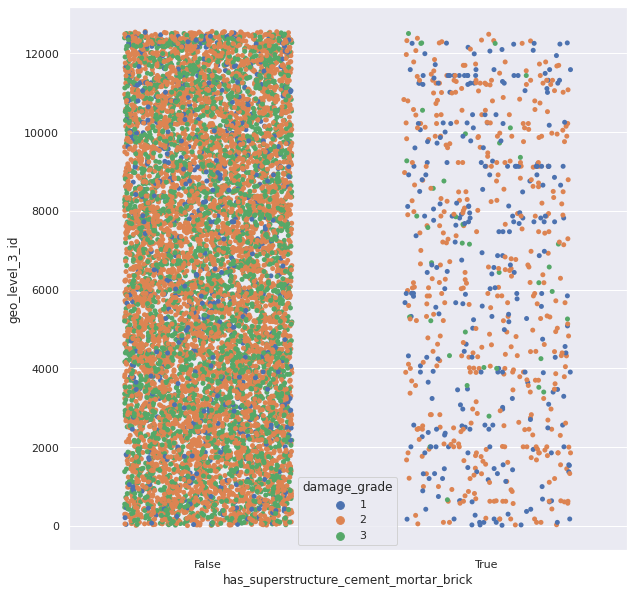

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.stripplot(x='has_superstructure_cement_mortar_brick', y='geo_level_3_id', 
              hue='damage_grade', data=df.iloc[:10000], jitter=0.3)
plt.show()

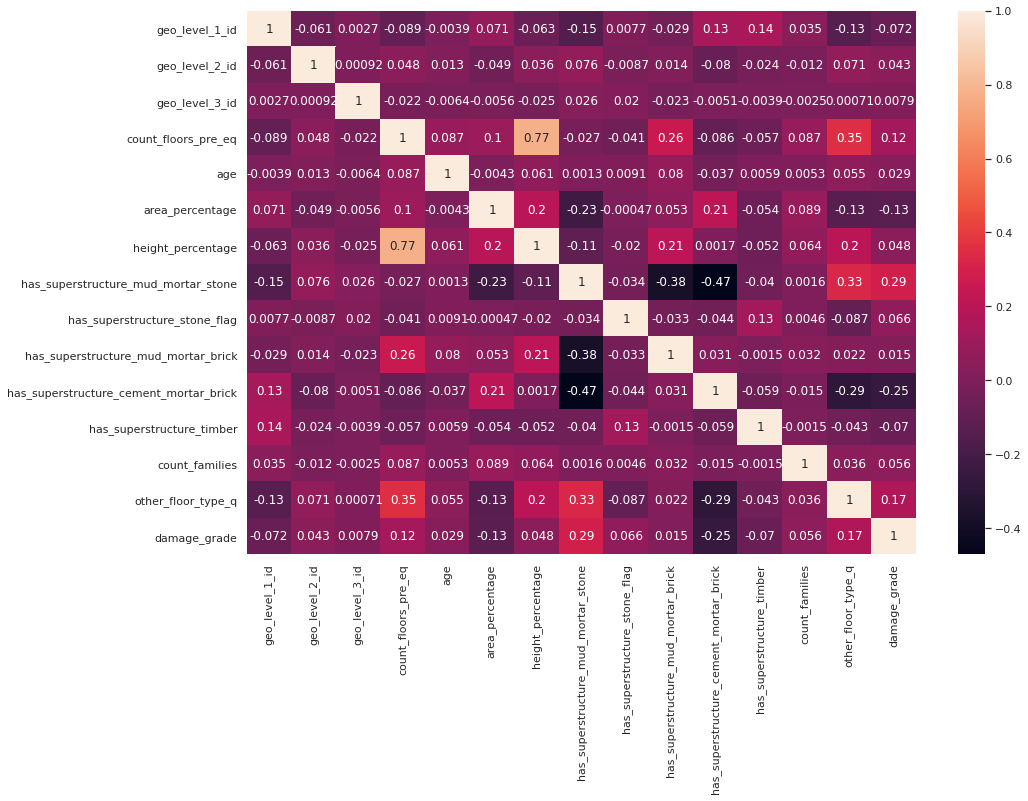

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [41]:
corr_of_all_variables = X.join(y).corr()
# sns.heatmap(X.join(y).corr().iloc[:, -1], annot=True)
# plt.show()

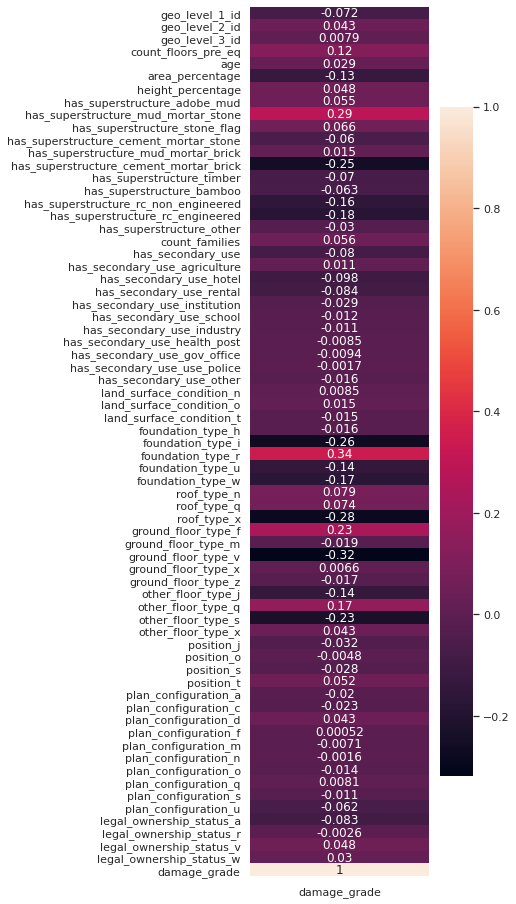

In [44]:
fig, ax = plt.subplots(figsize=plt.figaspect(5/1))
sns.heatmap(corr_of_all_variables[['damage_grade']], annot=True)
plt.show()

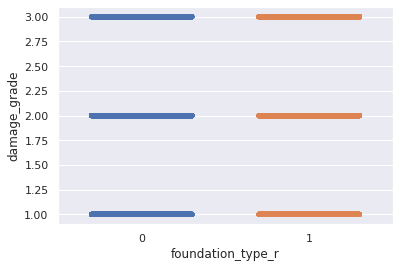

In [50]:
sns.stripplot(x='foundation_type_r', y='damage_grade', data=df_all, jitter=0.3)
plt.show()

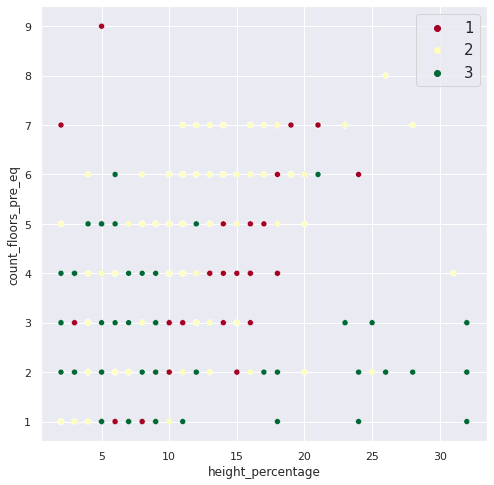

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='height_percentage',
                y='count_floors_pre_eq',
                data=df, hue='damage_grade', palette='RdYlGn')
plt.legend(loc='upper right', prop={'size': 15})
plt.show()

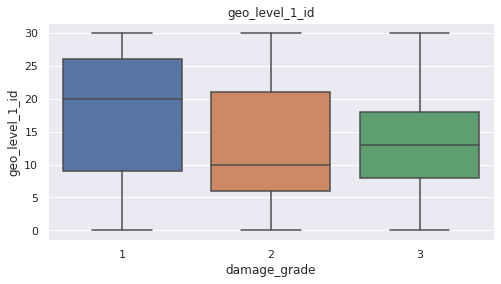

In [67]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
sns.boxplot(x='damage_grade', y='geo_level_1_id', data=df)
plt.title('geo_level_1_id')
plt.show()

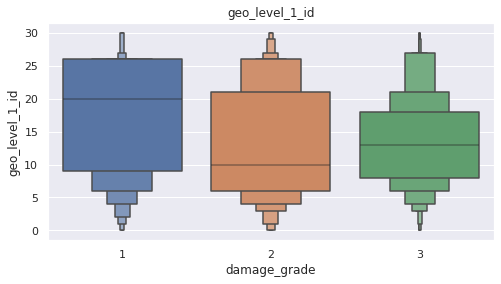

In [69]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
sns.boxenplot(x='damage_grade', y='geo_level_1_id', data=df)
plt.title('geo_level_1_id')
plt.show()

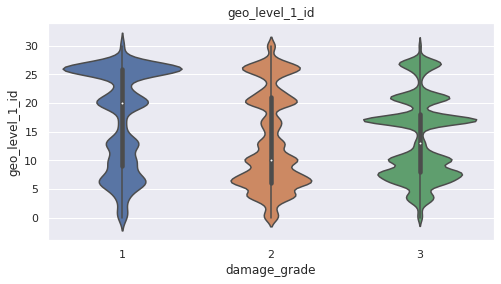

In [73]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
sns.violinplot(x='damage_grade', y='geo_level_1_id', data=df)
plt.title('geo_level_1_id')
plt.show()

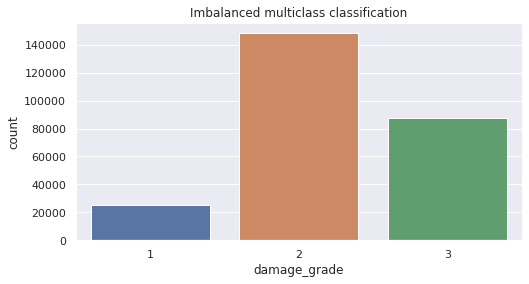

In [77]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/2))
sns.countplot(x='damage_grade', data=df)
plt.title('Imbalanced multiclass classification')
plt.show()

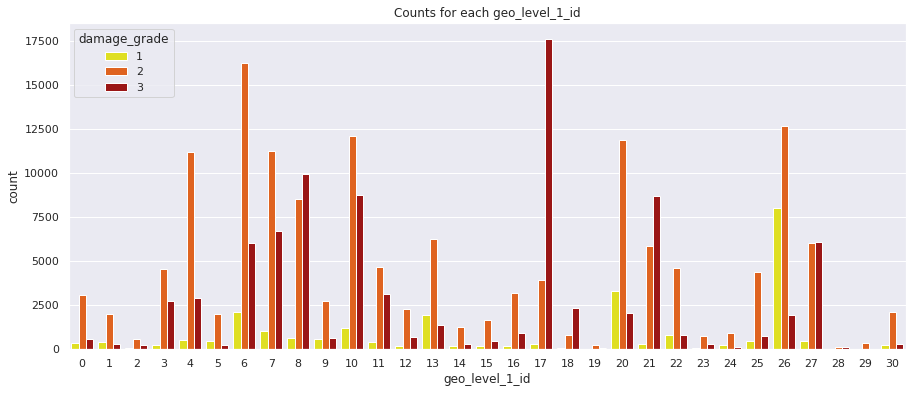

In [98]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x='geo_level_1_id', data=df, palette='hot_r', hue='damage_grade')
plt.title('Counts for each geo_level_1_id')
plt.show()

This is really interesting. There are some districts that are WAY more likely to be one damage grade than the others. This fits my prediction perfectly actually. For example, `geo_level_1_id` 17 is mostly damage grade 3, whereas 20 is grade 2. Not sure how to put this to use though. Some of the districts are increidbly powerful predictors, others are not. Could we highlight the worst hit districts and give them a stronger rating and give other districts much lower ratings?

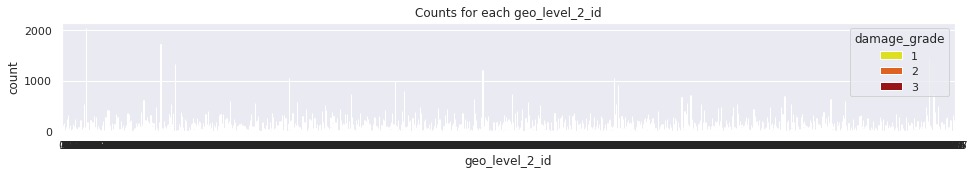

In [104]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/10))
sns.countplot(x='geo_level_2_id', data=df, palette='hot_r', hue='damage_grade')
plt.title('Counts for each geo_level_2_id')
plt.show()

In [103]:
df.geo_level_2_id.describe()

count    260601.000000
mean        701.074685
std         412.710734
min           0.000000
25%         350.000000
50%         702.000000
75%        1050.000000
max        1427.000000
Name: geo_level_2_id, dtype: float64

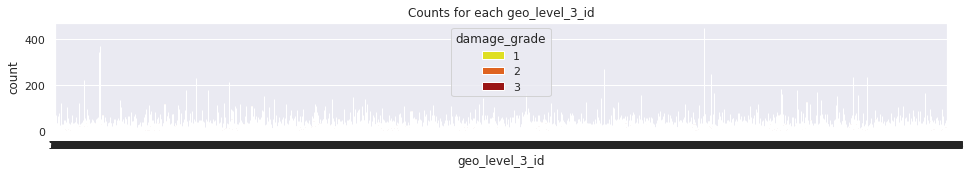

In [105]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/10))
sns.countplot(x='geo_level_3_id', data=df, palette='hot_r', hue='damage_grade')
plt.title('Counts for each geo_level_3_id')
plt.show()

## Lasso Regression To Select Most Important Linear Features

In [16]:
X_dummies = pd.get_dummies(X)

In [10]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(pd.get_dummies(X), np.ravel(y))

Lasso()

In [15]:
len(pd.get_dummies(X).columns)

68

In [14]:
for alpha in [0.001, 0.01, 0.1, 1]:
    lasso = Lasso(alpha=alpha)
    lasso.fit(pd.get_dummies(X), np.ravel(y))
    print('Alpha:                ', alpha)
    print('Num features selected:', sum(lasso.coef_ > 0))

Alpha:                 0.001
Num features selected: 19
Alpha:                 0.01
Num features selected: 11
Alpha:                 0.1
Num features selected: 3
Alpha:                 1
Num features selected: 3


In [20]:
lasso_001 = Lasso(alpha=0.01)
lasso_001.fit(X_dummies, np.ravel(y))

Lasso(alpha=0.01)

In [26]:
lasso_series = pd.Series(data=lasso_001.coef_, index=X_dummies.columns)
lasso_series_important = lasso_series[lasso_series != 0]
lasso_series_important.sort_values(ascending=False, key=abs)

foundation_type_r                      2.780486e-01
ground_floor_type_v                   -2.138097e-01
has_superstructure_mud_mortar_stone    1.446325e-01
count_floors_pre_eq                    5.414635e-02
position_t                             2.520621e-02
has_superstructure_timber             -2.353022e-02
roof_type_x                           -2.124300e-02
roof_type_q                            1.974032e-02
ground_floor_type_f                    1.145815e-02
count_families                         6.763909e-03
area_percentage                       -5.124924e-03
height_percentage                      3.660955e-03
age                                    3.657082e-05
geo_level_2_id                         6.969505e-06
geo_level_3_id                         9.799384e-07
dtype: float64

# Questions

- Does it matter if we have the `has_` columns as categories or bools? What negative things would happen if they were `category` dtype?